In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd 
pd.set_option('display.max_columns', None)

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFE

import statsmodels.api as sm 

import pickle

In [2]:
df = pd.read_csv('../../cleaned_accepted_2007_to_2015Q4.csv.gz')
df.drop(columns='Unnamed: 0', inplace=True)

In [3]:
#term 0 is 36 months term = 1 is 60 months
df = df[df['term'] == 0]

In [4]:
# 0 is fully paid 1 is defaulted
df.loan_status.value_counts()

0    534414
1     86751
Name: loan_status, dtype: int64

In [5]:
# x = df.values
# min_max_scaler = preprocessing.MinMaxScaler()
# x_scaled = min_max_scaler.fit_transform(x)
# df = pd.DataFrame(x_scaled)

In [6]:
normalized_df= (df-df.min())/(df.max()-df.min())

normalized_df.drop(columns='term', inplace=True)

normalized_df['grade'] = df['grade']

In [7]:
normalized_df.sample(7)

,grade,issue_month,issue_year,annual_inc,dti,emp_length,funded_amnt,inq_fi,inq_last_12m,installment,int_rate,loan_status,loan_amnt,open_acc,percent_bc_gt_75,pub_rec,pub_rec_bankruptcies,tax_liens,total_acc,revol_bal,delinq_amnt,delinq_2yrs,mths_since_last_delinq,mths_since_last_major_derog,cr_yeargap,avg_fico_score,ownership_0,ownership_1,ownership_2,purpose_0,purpose_1,purpose_10,purpose_11,purpose_12,purpose_13,purpose_2,purpose_4,purpose_5,purpose_6,purpose_7,purpose_8,purpose_9,sub_grade_A1,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5
723206,1,0.909091,0.750,0.006667,0.015115,1.000000,0.681159,0.055526,0.069815,0.539041,0.239544,0.0,0.681159,0.142857,0.250,0.000000,0.0,0.0,0.177515,0.007387,0.0,0.0,0.000000,0.0,0.185714,0.403397,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
466290,4,0.818182,0.875,0.008444,0.025606,0.444444,0.710145,0.055526,0.069815,0.630319,0.577524,0.0,0.710145,0.202381,0.833,0.000000,0.0,0.0,0.147929,0.005069,0.0,0.0,0.000000,0.0,0.128571,0.339703,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
532584,1,0.545455,0.875,0.015556,0.017327,0.000000,0.449275,0.055526,0.069815,0.346544,0.162653,0.0,0.449275,0.083333,0.750,0.000000,0.0,0.0,0.082840,0.009327,0.0,0.0,0.000000,0.0,0.414286,0.382166,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
148329,1,0.727273,1.000,0.008333,0.021081,0.000000,0.249275,0.055526,0.069815,0.189954,0.120828,0.0,0.249275,0.142857,1.000,0.000000,0.0,0.0,0.118343,0.005970,0.0,0.0,0.000000,0.0,0.185714,0.382166,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
621823,0,0.181818,0.875,0.016667,0.019520,1.000000,0.797101,0.055526,0.069815,0.611324,0.151246,0.0,0.797101,0.309524,0.444,0.000000,0.0,0.0,0.319527,0.015168,0.0,0.0,0.000000,0.0,0.200000,0.339703,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
187522,2,0.636364,1.000,0.008333,0.011932,1.000000,0.449275,0.055526,0.069815,0.372182,0.366286,0.0,0.449275,0.095238,0.500,0.000000,0.0,0.0,0.071006,0.003630,0.0,0.0,0.148936,0.0,0.100000,0.254777,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
275590,1,0.363636,1.000,0.008889,0.003443,0.000000,0.333333,0.055526,0.069815,0.253610,0.120828,0.0,0.333333,0.059524,0.000,0.011628,0.0,0.0,0.059172,0.002608,0.0,0.0,0.000000,0.0,0.157143,0.297240,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Feature Selection

In [8]:
X = normalized_df[['issue_month', 'issue_year', 'annual_inc', 'dti',
       'emp_length', 'funded_amnt', 'inq_fi', 'inq_last_12m', 'installment',
       'int_rate', 'loan_amnt', 'open_acc', 'percent_bc_gt_75',
       'pub_rec', 'pub_rec_bankruptcies', 'tax_liens', 'total_acc',
       'revol_bal', 'delinq_amnt', 'delinq_2yrs', 'mths_since_last_delinq',
       'mths_since_last_major_derog', 'cr_yeargap', 'avg_fico_score']].copy()

# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data["feature"] = X.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                          for i in range(len(X.columns))] 
  
print(vif_data)

                        feature          VIF
0                   issue_month     3.989168
1                    issue_year    24.060365
2                    annual_inc     2.831421
3                           dti     6.834030
4                    emp_length     3.358245
5                   funded_amnt  5261.743268
6                        inq_fi    28.204937
7                  inq_last_12m    45.414391
8                   installment   983.485966
9                      int_rate    12.889283
10                    loan_amnt  4245.531399
11                     open_acc    11.959968
12             percent_bc_gt_75     3.608975
13                      pub_rec     9.329429
14         pub_rec_bankruptcies     4.531955
15                    tax_liens     5.071770
16                    total_acc    12.011278
17                    revol_bal     1.950958
18                  delinq_amnt     1.001648
19                  delinq_2yrs     1.260462
20       mths_since_last_delinq     2.227751
21  mths_s

In [9]:
# try model still including 'int_rate', 'avg_fico_score', 'loan_amnt', 'pub_rec'

X_trim = normalized_df[['issue_month', 'annual_inc', 'dti', 'emp_length',
       'int_rate', 'percent_bc_gt_75',
       'pub_rec_bankruptcies', 'tax_liens',
       'revol_bal', 'delinq_amnt', 'delinq_2yrs', 'mths_since_last_delinq',
       'mths_since_last_major_derog', 'cr_yeargap']].copy()

# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data["feature"] = X_trim.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(X_trim.values, i) 
                          for i in range(len(X_trim.columns))] 
  
print(vif_data)

                        feature       VIF
0                   issue_month  3.416179
1                    annual_inc  2.359530
2                           dti  4.943491
3                    emp_length  3.227646
4                      int_rate  4.094910
5              percent_bc_gt_75  3.279367
6          pub_rec_bankruptcies  1.169643
7                     tax_liens  1.022160
8                     revol_bal  1.817180
9                   delinq_amnt  1.001520
10                  delinq_2yrs  1.179934
11       mths_since_last_delinq  2.173353
12  mths_since_last_major_derog  1.814009
13                   cr_yeargap  5.159983


In [10]:
X = normalized_df[['loan_amnt', 'issue_month', 'annual_inc', 'dti', 'emp_length',
       'int_rate', 'percent_bc_gt_75', 'pub_rec_bankruptcies',
       'tax_liens', 'revol_bal', 'delinq_amnt', 'delinq_2yrs', 
       'mths_since_last_delinq', 'mths_since_last_major_derog', 'cr_yeargap',
       'ownership_0', 'ownership_1', 'ownership_2', 'purpose_0', 'purpose_1',
       'purpose_10', 'purpose_11', 'purpose_12', 'purpose_13', 'purpose_2',
       'purpose_4', 'purpose_5', 'purpose_6', 'purpose_7', 'purpose_8',
       'purpose_9', 'sub_grade_A1', 'sub_grade_A2', 'sub_grade_A3',
       'sub_grade_A4', 'sub_grade_A5', 'sub_grade_B1', 'sub_grade_B2',
       'sub_grade_B3', 'sub_grade_B4', 'sub_grade_B5', 'sub_grade_C1',
       'sub_grade_C2', 'sub_grade_C3', 'sub_grade_C4', 'sub_grade_C5',
       'sub_grade_D1', 'sub_grade_D2', 'sub_grade_D3', 'sub_grade_D4',
       'sub_grade_D5', 'sub_grade_E1', 'sub_grade_E2', 'sub_grade_E3',
       'sub_grade_E4', 'sub_grade_E5', 'sub_grade_F1', 'sub_grade_F2',
       'sub_grade_F3', 'sub_grade_F4', 'sub_grade_F5', 'sub_grade_G1',
       'sub_grade_G2', 'sub_grade_G3', 'sub_grade_G4', 'sub_grade_G5']].copy()
    
y = normalized_df['loan_status']
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27, shuffle=True)


In [11]:
logistic_norm = LogisticRegression(C=1e-04, l1_ratio=0.3, solver='saga', multi_class='auto', penalty='elasticnet', class_weight='balanced', random_state=27, n_jobs=7)
logistic_norm.fit(X_train, y_train)


LogisticRegression(C=0.0001, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=0.3,
                   max_iter=100, multi_class='auto', n_jobs=7,
                   penalty='elasticnet', random_state=27, solver='saga',
                   tol=0.0001, verbose=0, warm_start=False)

In [12]:
print('accuracy: ', logistic_norm.score(X_test, y_test))

predictions_norm = logistic_norm.predict(X_test)
cm_norm = confusion_matrix(y_test, predictions_norm)
print(cm_norm)


accuracy:  0.5939323690162839
[[63266 43496]
 [ 6951 10520]]


In [13]:
log_odds_norm = logistic_norm.coef_[0]
log_odds_norm

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.70558926,  0.12409302,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.16563796,  0.0804067 ,  0.        ,  0.        , -0.06084218,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.03660151,  0.        ,  0.        , -0.02557017,
       -0.01774378,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ])

In [14]:
temp = pd.DataFrame(log_odds_norm, 
             X.columns, columns=['coef'])
temp['coef'] = abs(temp['coef'])
temp = temp.sort_values(by='coef', ascending=True)
temp

,coef
loan_amnt,0.000000
sub_grade_B1,0.000000
sub_grade_B2,0.000000
sub_grade_B3,0.000000
sub_grade_B4,0.000000
...,...
purpose_1,0.060842
ownership_1,0.080407
percent_bc_gt_75,0.124093
ownership_0,0.165638


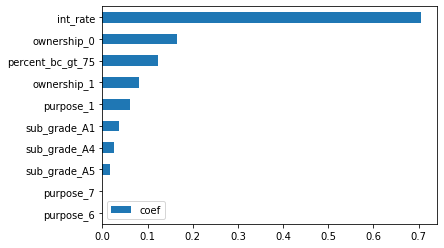

In [15]:
temp.tail(10).plot.barh(by='index', y='coef')

In [16]:
X = df[['int_rate', 'loan_amnt', 'issue_month', 'annual_inc', 'dti', 'emp_length',
       'percent_bc_gt_75', 'pub_rec_bankruptcies',
       'tax_liens', 'revol_bal', 'delinq_amnt', 'delinq_2yrs', 
       'mths_since_last_delinq', 'mths_since_last_major_derog', 'cr_yeargap',
       'ownership_0', 'ownership_1', 'ownership_2', 'purpose_0', 'purpose_1',
       'purpose_10', 'purpose_11', 'purpose_12', 'purpose_13', 'purpose_2',
       'purpose_4', 'purpose_5', 'purpose_6', 'purpose_7', 'purpose_8',
       'purpose_9', 'sub_grade_A1', 'sub_grade_A2', 'sub_grade_A3',
       'sub_grade_A4', 'sub_grade_A5', 'sub_grade_B1', 'sub_grade_B2',
       'sub_grade_B3', 'sub_grade_B4', 'sub_grade_B5', 'sub_grade_C1',
       'sub_grade_C2', 'sub_grade_C3', 'sub_grade_C4', 'sub_grade_C5',
       'sub_grade_D1', 'sub_grade_D2', 'sub_grade_D3', 'sub_grade_D4',
       'sub_grade_D5', 'sub_grade_E1', 'sub_grade_E2', 'sub_grade_E3',
       'sub_grade_E4', 'sub_grade_E5', 'sub_grade_F1', 'sub_grade_F2',
       'sub_grade_F3', 'sub_grade_F4', 'sub_grade_F5', 'sub_grade_G1',
       'sub_grade_G2', 'sub_grade_G3', 'sub_grade_G4', 'sub_grade_G5']].copy()
    
y = df['loan_status']
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27, shuffle=True)

In [17]:
logistic = LogisticRegression(C=1e-04, l1_ratio=0.3, solver='saga', multi_class='auto', penalty='elasticnet', class_weight='balanced', random_state=27, n_jobs=7)
logistic.fit(X_train, y_train)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=0.0001, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=0.3,
                   max_iter=100, multi_class='auto', n_jobs=7,
                   penalty='elasticnet', random_state=27, solver='saga',
                   tol=0.0001, verbose=0, warm_start=False)

In [18]:
print('accuracy: ', logistic.score(X_test, y_test))

predictions = logistic.predict(X_test)
cm = confusion_matrix(y_test, predictions)
print(cm)


accuracy:  0.6544396416411099
[[74504 32258]
 [10672  6799]]


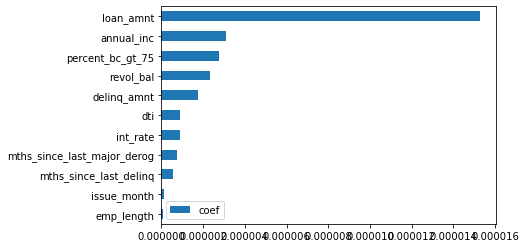

In [19]:
log_odds = logistic.coef_[0]

temp = pd.DataFrame(log_odds, 
             X.columns, columns=['coef'])
temp['coef'] = abs(temp['coef'])
temp = temp.sort_values(by='coef', ascending=True)

temp.tail(11).plot.barh(by='index', y='coef')

In [20]:
r = permutation_importance(logistic, X_test, y_test,
                          n_repeats=30,
                          random_state=27)

for i in r.importances_mean.argsort()[::-1]:
    if abs(r.importances_mean[i]) - 2*r.importances_std[i] > 0:
        print(f"{X.columns[i]:}"
             f"{r.importances_mean[i]:.3f}"
             f" +/- {r.importances_std[i]:.3f}"
             )

In [21]:
for i, c in enumerate(X.columns):
    print(c, logistic.coef_[:,i])

int_rate [8.76849314e-07]
loan_amnt [1.52794305e-05]
issue_month [1.3052623e-07]
annual_inc [3.09869119e-06]
dti [8.90213205e-07]
emp_length [1.00358843e-07]
percent_bc_gt_75 [2.75103051e-06]
pub_rec_bankruptcies [3.59345094e-09]
tax_liens [0.]
revol_bal [2.34768475e-06]
delinq_amnt [1.77719904e-06]
delinq_2yrs [1.29828641e-08]
mths_since_last_delinq [5.50186681e-07]
mths_since_last_major_derog [7.5089702e-07]
cr_yeargap [4.44763149e-08]
ownership_0 [1.22993673e-08]
ownership_1 [2.69852906e-08]
ownership_2 [0.]
purpose_0 [1.07821747e-08]
purpose_1 [3.31003588e-09]
purpose_10 [0.]
purpose_11 [0.]
purpose_12 [0.]
purpose_13 [0.]
purpose_2 [0.]
purpose_4 [0.]
purpose_5 [0.]
purpose_6 [0.]
purpose_7 [0.]
purpose_8 [0.]
purpose_9 [0.]
sub_grade_A1 [2.39043523e-09]
sub_grade_A2 [1.13257252e-09]
sub_grade_A3 [6.04818444e-10]
sub_grade_A4 [2.38903561e-09]
sub_grade_A5 [2.17875409e-09]
sub_grade_B1 [0.]
sub_grade_B2 [0.]
sub_grade_B3 [0.]
sub_grade_B4 [0.]
sub_grade_B5 [0.]
sub_grade_C1 [0.]
su

In [22]:
# # Grid search cross validation
# grid={'C':[1e-5, 1e-4, 1e-3, 1e-2, 1e-1], 'l1_ratio':[0, 0.2, 0.4, 0.6, 0.8, 1]}

# logistic = LogisticRegression(solver='saga', multi_class='auto', penalty='elasticnet', class_weight='balanced', random_state=27, n_jobs=7)
# logistic_cv = GridSearchCV(logistic, grid, cv=5)
# logistic_cv.fit(X_train, y_train)

# print('Tuned hyperparameters : (best parameters) ', logistic_cv.best_params_)
# print('accuracy: ', logistic_cv.best_score_)



# no usable results as accuracy score does not give enough information. null model gets 80% accuracy.


## Model Loan Grades

In [23]:
df_AB = df[df['grade'].isin([0,1])]
df_AB.sample(8)

,term,grade,issue_month,issue_year,annual_inc,dti,emp_length,funded_amnt,inq_fi,inq_last_12m,installment,int_rate,loan_status,loan_amnt,open_acc,percent_bc_gt_75,pub_rec,pub_rec_bankruptcies,tax_liens,total_acc,revol_bal,delinq_amnt,delinq_2yrs,mths_since_last_delinq,mths_since_last_major_derog,cr_yeargap,avg_fico_score,ownership_0,ownership_1,ownership_2,purpose_0,purpose_1,purpose_10,purpose_11,purpose_12,purpose_13,purpose_2,purpose_4,purpose_5,purpose_6,purpose_7,purpose_8,purpose_9,sub_grade_A1,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5
420249,0,0,1.0,2015.0,65000.0,26.07,10,16000.0,0.943945,2.234091,497.63,7.49,0,16000.0,10.0,100.00000,0.0,0.0,0.0,16.0,33960.0,0.0,0.0,0.0,0.0,22.0,707.0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
78245,0,1,11.0,2015.0,40000.0,18.90,2,5000.0,0.943945,2.234091,159.40,9.17,0,5000.0,9.0,0.00000,0.0,0.0,0.0,18.0,3462.0,0.0,0.0,54.0,0.0,15.0,707.0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
221067,0,1,7.0,2015.0,73000.0,20.65,4,10000.0,0.943945,2.234091,314.20,8.18,0,10000.0,9.0,66.70000,0.0,0.0,0.0,17.0,25234.0,0.0,0.0,0.0,0.0,14.0,692.0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
714859,0,1,11.0,2013.0,74200.0,25.59,10,12000.0,0.943945,2.234091,404.27,12.99,0,12000.0,15.0,66.70000,0.0,0.0,0.0,28.0,30200.0,0.0,0.0,0.0,0.0,28.0,722.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
753763,0,1,9.0,2013.0,49000.0,29.39,4,9000.0,0.943945,2.234091,297.00,11.55,0,9000.0,14.0,16.70000,1.0,1.0,0.0,19.0,7503.0,0.0,0.0,0.0,0.0,18.0,717.0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
168825,0,0,8.0,2015.0,49000.0,1.61,9,5000.0,0.943945,2.234091,154.99,7.26,0,5000.0,6.0,0.00000,1.0,1.0,0.0,13.0,2370.0,0.0,0.0,36.0,0.0,22.0,682.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
677828,0,0,1.0,2011.0,71352.0,7.97,3,9000.0,0.943945,2.234091,276.01,6.54,0,9000.0,14.0,49.74199,0.0,0.0,0.0,29.0,3460.0,0.0,0.0,0.0,0.0,6.0,727.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
792587,0,0,5.0,2013.0,42000.0,15.57,1,8400.0,0.943945,2.234091,261.76,7.62,1,8400.0,7.0,0.00000,0.0,0.0,0.0,14.0,7215.0,0.0,0.0,0.0,0.0,19.0,792.0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [24]:
X_AB = df_AB[['int_rate', 'loan_amnt', 'issue_month', 'annual_inc', 'dti', 'emp_length',
           'percent_bc_gt_75', 'pub_rec_bankruptcies', 
           'tax_liens', 'revol_bal', 'delinq_amnt', 'delinq_2yrs', 
           'mths_since_last_delinq', 'mths_since_last_major_derog', 'cr_yeargap',
           'ownership_0', 'ownership_1', 'ownership_2', 'purpose_0', 'purpose_1',
           'purpose_10', 'purpose_11', 'purpose_12', 'purpose_13', 'purpose_2',
           'purpose_4', 'purpose_5', 'purpose_6', 'purpose_7', 'purpose_8',
           'purpose_9', 'sub_grade_A1', 'sub_grade_A2', 'sub_grade_A3',
           'sub_grade_A4', 'sub_grade_A5', 'sub_grade_B1', 'sub_grade_B2',
           'sub_grade_B3', 'sub_grade_B4', 'sub_grade_B5', 'sub_grade_C1',
           'sub_grade_C2', 'sub_grade_C3', 'sub_grade_C4', 'sub_grade_C5',
           'sub_grade_D1', 'sub_grade_D2', 'sub_grade_D3', 'sub_grade_D4',
           'sub_grade_D5', 'sub_grade_E1', 'sub_grade_E2', 'sub_grade_E3',
           'sub_grade_E4', 'sub_grade_E5', 'sub_grade_F1', 'sub_grade_F2',
           'sub_grade_F3', 'sub_grade_F4', 'sub_grade_F5', 'sub_grade_G1',
           'sub_grade_G2', 'sub_grade_G3', 'sub_grade_G4', 'sub_grade_G5']].copy()
    
y_AB = df_AB['loan_status']

X_train_AB, X_test_AB, y_train_AB, y_test_AB = train_test_split(X_AB, y_AB, test_size=0.2, random_state=27, shuffle=True)

In [25]:
logistic_AB = LogisticRegression(max_iter=1000, C=1e-04, l1_ratio=0.3, solver='saga', multi_class='auto', penalty='elasticnet', class_weight='balanced', random_state=27, n_jobs=7)

logistic_AB.fit(X_train_AB, y_train_AB)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=0.0001, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=0.3,
                   max_iter=1000, multi_class='auto', n_jobs=7,
                   penalty='elasticnet', random_state=27, solver='saga',
                   tol=0.0001, verbose=0, warm_start=False)

In [26]:
print('accuracy: ', logistic_AB.score(X_test_AB, y_test_AB))

predictions_AB = logistic_AB.predict(X_test_AB)
cm_AB = confusion_matrix(y_test_AB, predictions_AB)
print(cm_AB)

accuracy:  0.7117689306989254
[[48682 15976]
 [ 4491  1860]]


In [27]:
df_CD = df[df['grade'].isin([2,3])]

X_CD = df_CD[['int_rate', 'loan_amnt', 'issue_month', 'annual_inc', 'dti', 'emp_length',
           'percent_bc_gt_75', 'pub_rec_bankruptcies', 
           'tax_liens', 'revol_bal', 'delinq_amnt', 'delinq_2yrs', 
           'mths_since_last_delinq', 'mths_since_last_major_derog', 'cr_yeargap',
           'ownership_0', 'ownership_1', 'ownership_2', 'purpose_0', 'purpose_1',
           'purpose_10', 'purpose_11', 'purpose_12', 'purpose_13', 'purpose_2',
           'purpose_4', 'purpose_5', 'purpose_6', 'purpose_7', 'purpose_8',
           'purpose_9', 'sub_grade_A1', 'sub_grade_A2', 'sub_grade_A3',
           'sub_grade_A4', 'sub_grade_A5', 'sub_grade_B1', 'sub_grade_B2',
           'sub_grade_B3', 'sub_grade_B4', 'sub_grade_B5', 'sub_grade_C1',
           'sub_grade_C2', 'sub_grade_C3', 'sub_grade_C4', 'sub_grade_C5',
           'sub_grade_D1', 'sub_grade_D2', 'sub_grade_D3', 'sub_grade_D4',
           'sub_grade_D5', 'sub_grade_E1', 'sub_grade_E2', 'sub_grade_E3',
           'sub_grade_E4', 'sub_grade_E5', 'sub_grade_F1', 'sub_grade_F2',
           'sub_grade_F3', 'sub_grade_F4', 'sub_grade_F5', 'sub_grade_G1',
           'sub_grade_G2', 'sub_grade_G3', 'sub_grade_G4', 'sub_grade_G5']].copy()
    
y_CD = df_CD['loan_status']

X_train_CD, X_test_CD, y_train_CD, y_test_CD = train_test_split(X_CD, y_CD, test_size=0.2, random_state=27, shuffle=True)

In [28]:
logistic_CD = LogisticRegression(max_iter=1000, C=1e-04, l1_ratio=0.3, solver='saga', multi_class='auto', penalty='elasticnet', class_weight='balanced', random_state=27, n_jobs=7)

logistic_CD.fit(X_train_CD, y_train_CD)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=0.0001, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=0.3,
                   max_iter=1000, multi_class='auto', n_jobs=7,
                   penalty='elasticnet', random_state=27, solver='saga',
                   tol=0.0001, verbose=0, warm_start=False)

In [29]:
print('accuracy: ', logistic_CD.score(X_test_CD, y_test_CD))

predictions_CD = logistic_CD.predict(X_test_CD)
cm_CD = confusion_matrix(y_test_CD, predictions_CD)
print(cm_CD)

accuracy:  0.5664910299836908
[[22442 15928]
 [ 4805  4651]]


In [30]:
df_EFG = df[df['grade'].isin([4,5,6])]

X_EFG = df_EFG[['int_rate', 'loan_amnt', 'issue_month', 'annual_inc', 'dti', 'emp_length',
               'percent_bc_gt_75', 'pub_rec_bankruptcies', 
               'tax_liens', 'revol_bal', 'delinq_amnt', 'delinq_2yrs', 
               'mths_since_last_delinq', 'mths_since_last_major_derog', 'cr_yeargap',
               'ownership_0', 'ownership_1', 'ownership_2', 'purpose_0', 'purpose_1',
               'purpose_10', 'purpose_11', 'purpose_12', 'purpose_13', 'purpose_2',
               'purpose_4', 'purpose_5', 'purpose_6', 'purpose_7', 'purpose_8',
               'purpose_9', 'sub_grade_A1', 'sub_grade_A2', 'sub_grade_A3',
               'sub_grade_A4', 'sub_grade_A5', 'sub_grade_B1', 'sub_grade_B2',
               'sub_grade_B3', 'sub_grade_B4', 'sub_grade_B5', 'sub_grade_C1',
               'sub_grade_C2', 'sub_grade_C3', 'sub_grade_C4', 'sub_grade_C5',
               'sub_grade_D1', 'sub_grade_D2', 'sub_grade_D3', 'sub_grade_D4',
               'sub_grade_D5', 'sub_grade_E1', 'sub_grade_E2', 'sub_grade_E3',
               'sub_grade_E4', 'sub_grade_E5', 'sub_grade_F1', 'sub_grade_F2',
               'sub_grade_F3', 'sub_grade_F4', 'sub_grade_F5', 'sub_grade_G1',
               'sub_grade_G2', 'sub_grade_G3', 'sub_grade_G4', 'sub_grade_G5']].copy()
    
y_EFG = df_EFG['loan_status']
    
X_train_EFG, X_test_EFG, y_train_EFG, y_test_EFG = train_test_split(X_EFG, y_EFG, test_size=0.2, random_state=27, shuffle=True)

In [31]:
logistic_EFG = LogisticRegression(max_iter=1000, C=1e-04, l1_ratio=0.3, solver='saga', multi_class='auto', penalty='elasticnet', class_weight='balanced', random_state=27, n_jobs=7)

logistic_EFG.fit(X_train_EFG, y_train_EFG)


LogisticRegression(C=0.0001, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=0.3,
                   max_iter=1000, multi_class='auto', n_jobs=7,
                   penalty='elasticnet', random_state=27, solver='saga',
                   tol=0.0001, verbose=0, warm_start=False)

In [32]:
print('accuracy: ', logistic_EFG.score(X_test_EFG, y_test_EFG))

predictions_EFG = logistic_EFG.predict(X_test_EFG)
cm_EFG = confusion_matrix(y_test_EFG, predictions_EFG)
print(cm_EFG)

accuracy:  0.505
[[1772 2047]
 [ 626  955]]


In [33]:
df_A = df[df['grade'].isin([0])]

X_A = df_A[['int_rate', 'loan_amnt', 'issue_month', 'annual_inc', 'dti', 'emp_length',
           'percent_bc_gt_75', 'pub_rec_bankruptcies', 
           'tax_liens', 'revol_bal', 'delinq_amnt', 'delinq_2yrs', 
           'mths_since_last_delinq', 'mths_since_last_major_derog', 'cr_yeargap',
           'ownership_0', 'ownership_1', 'ownership_2', 'purpose_0', 'purpose_1',
           'purpose_10', 'purpose_11', 'purpose_12', 'purpose_13', 'purpose_2',
           'purpose_4', 'purpose_5', 'purpose_6', 'purpose_7', 'purpose_8',
           'purpose_9', 'sub_grade_A1', 'sub_grade_A2', 'sub_grade_A3',
           'sub_grade_A4', 'sub_grade_A5', 'sub_grade_B1', 'sub_grade_B2',
           'sub_grade_B3', 'sub_grade_B4', 'sub_grade_B5', 'sub_grade_C1',
           'sub_grade_C2', 'sub_grade_C3', 'sub_grade_C4', 'sub_grade_C5',
           'sub_grade_D1', 'sub_grade_D2', 'sub_grade_D3', 'sub_grade_D4',
           'sub_grade_D5', 'sub_grade_E1', 'sub_grade_E2', 'sub_grade_E3',
           'sub_grade_E4', 'sub_grade_E5', 'sub_grade_F1', 'sub_grade_F2',
           'sub_grade_F3', 'sub_grade_F4', 'sub_grade_F5', 'sub_grade_G1',
           'sub_grade_G2', 'sub_grade_G3', 'sub_grade_G4', 'sub_grade_G5']].copy()
    
y_A = df_A['loan_status']
    
X_train_A, X_test_A, y_train_A, y_test_A = train_test_split(X_A, y_A, test_size=0.2, random_state=27, shuffle=True)

In [34]:
logistic_A = LogisticRegression(max_iter=1000, C=1e-04, l1_ratio=0.3, solver='saga', multi_class='auto', penalty='elasticnet', class_weight='balanced', random_state=27, n_jobs=7)
logistic_A.fit(X_train_A, y_train_A)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=0.0001, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=0.3,
                   max_iter=1000, multi_class='auto', n_jobs=7,
                   penalty='elasticnet', random_state=27, solver='saga',
                   tol=0.0001, verbose=0, warm_start=False)

In [35]:
print('accuracy: ', logistic_A.score(X_test_A, y_test_A))

predictions_A = logistic_A.predict(X_test_A)
cm_A = confusion_matrix(y_test_A, predictions_A)
print(cm_A)

accuracy:  0.7364005034260942
[[20616  6441]
 [ 1099   448]]


In [36]:
df_B = df[df['grade'].isin([1])]

X_B = df_B[['int_rate', 'loan_amnt', 'issue_month', 'annual_inc', 'dti', 'emp_length',
           'percent_bc_gt_75', 'pub_rec_bankruptcies', 
           'tax_liens', 'revol_bal', 'delinq_amnt', 'delinq_2yrs', 
           'mths_since_last_delinq', 'mths_since_last_major_derog', 'cr_yeargap',
           'ownership_0', 'ownership_1', 'ownership_2', 'purpose_0', 'purpose_1',
           'purpose_10', 'purpose_11', 'purpose_12', 'purpose_13', 'purpose_2',
           'purpose_4', 'purpose_5', 'purpose_6', 'purpose_7', 'purpose_8',
           'purpose_9', 'sub_grade_A1', 'sub_grade_A2', 'sub_grade_A3',
           'sub_grade_A4', 'sub_grade_A5', 'sub_grade_B1', 'sub_grade_B2',
           'sub_grade_B3', 'sub_grade_B4', 'sub_grade_B5', 'sub_grade_C1',
           'sub_grade_C2', 'sub_grade_C3', 'sub_grade_C4', 'sub_grade_C5',
           'sub_grade_D1', 'sub_grade_D2', 'sub_grade_D3', 'sub_grade_D4',
           'sub_grade_D5', 'sub_grade_E1', 'sub_grade_E2', 'sub_grade_E3',
           'sub_grade_E4', 'sub_grade_E5', 'sub_grade_F1', 'sub_grade_F2',
           'sub_grade_F3', 'sub_grade_F4', 'sub_grade_F5', 'sub_grade_G1',
           'sub_grade_G2', 'sub_grade_G3', 'sub_grade_G4', 'sub_grade_G5']].copy()
    
y_B = df_B['loan_status']
    
X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(X_B, y_B, test_size=0.2, random_state=27, shuffle=True)

In [37]:
logistic_B = LogisticRegression(max_iter=1000, C=1e-04, l1_ratio=0.3, solver='saga', multi_class='auto', penalty='elasticnet', class_weight='balanced', random_state=27, n_jobs=7)
logistic_B.fit(X_train_B, y_train_B)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=0.0001, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=0.3,
                   max_iter=1000, multi_class='auto', n_jobs=7,
                   penalty='elasticnet', random_state=27, solver='saga',
                   tol=0.0001, verbose=0, warm_start=False)

In [38]:
print('accuracy: ', logistic_B.score(X_test_B, y_test_B))

predictions_B = logistic_B.predict(X_test_B)
cm_B = confusion_matrix(y_test_B, predictions_B)
print(cm_B)

accuracy:  0.6494517155995755
[[25808 11887]
 [ 2978  1732]]


In [39]:
df_C = df[df['grade'].isin([2])]

X_C = df_C[['int_rate', 'loan_amnt', 'issue_month', 'annual_inc', 'dti', 'emp_length',
           'percent_bc_gt_75', 'pub_rec_bankruptcies', 
           'tax_liens', 'revol_bal', 'delinq_amnt', 'delinq_2yrs', 
           'mths_since_last_delinq', 'mths_since_last_major_derog', 'cr_yeargap',
           'ownership_0', 'ownership_1', 'ownership_2', 'purpose_0', 'purpose_1',
           'purpose_10', 'purpose_11', 'purpose_12', 'purpose_13', 'purpose_2',
           'purpose_4', 'purpose_5', 'purpose_6', 'purpose_7', 'purpose_8',
           'purpose_9', 'sub_grade_A1', 'sub_grade_A2', 'sub_grade_A3',
           'sub_grade_A4', 'sub_grade_A5', 'sub_grade_B1', 'sub_grade_B2',
           'sub_grade_B3', 'sub_grade_B4', 'sub_grade_B5', 'sub_grade_C1',
           'sub_grade_C2', 'sub_grade_C3', 'sub_grade_C4', 'sub_grade_C5',
           'sub_grade_D1', 'sub_grade_D2', 'sub_grade_D3', 'sub_grade_D4',
           'sub_grade_D5', 'sub_grade_E1', 'sub_grade_E2', 'sub_grade_E3',
           'sub_grade_E4', 'sub_grade_E5', 'sub_grade_F1', 'sub_grade_F2',
           'sub_grade_F3', 'sub_grade_F4', 'sub_grade_F5', 'sub_grade_G1',
           'sub_grade_G2', 'sub_grade_G3', 'sub_grade_G4', 'sub_grade_G5']].copy()
    
y_C = df_C['loan_status']
    
X_train_C, X_test_C, y_train_C, y_test_C = train_test_split(X_C, y_C, test_size=0.2, random_state=27, shuffle=True)

In [40]:
logistic_C = LogisticRegression(max_iter=1000, C=1e-04, l1_ratio=0.3, solver='saga', multi_class='auto', penalty='elasticnet', class_weight='balanced', random_state=27, n_jobs=7)
logistic_C.fit(X_train_C, y_train_C)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=0.0001, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=0.3,
                   max_iter=1000, multi_class='auto', n_jobs=7,
                   penalty='elasticnet', random_state=27, solver='saga',
                   tol=0.0001, verbose=0, warm_start=False)

In [41]:
print('accuracy: ', logistic_C.score(X_test_C, y_test_C))

predictions_C = logistic_C.predict(X_test_C)
cm_C = confusion_matrix(y_test_C, predictions_C)
print(cm_C)

accuracy:  0.5900640236394976
[[16641  9914]
 [ 3404  2529]]


In [42]:
df_D = df[df['grade'].isin([3])]

X_D = df_D[['int_rate', 'loan_amnt', 'issue_month', 'annual_inc', 'dti', 'emp_length',
           'percent_bc_gt_75', 'pub_rec_bankruptcies', 
           'tax_liens', 'revol_bal', 'delinq_amnt', 'delinq_2yrs', 
           'mths_since_last_delinq', 'mths_since_last_major_derog', 'cr_yeargap',
           'ownership_0', 'ownership_1', 'ownership_2', 'purpose_0', 'purpose_1',
           'purpose_10', 'purpose_11', 'purpose_12', 'purpose_13', 'purpose_2',
           'purpose_4', 'purpose_5', 'purpose_6', 'purpose_7', 'purpose_8',
           'purpose_9', 'sub_grade_A1', 'sub_grade_A2', 'sub_grade_A3',
           'sub_grade_A4', 'sub_grade_A5', 'sub_grade_B1', 'sub_grade_B2',
           'sub_grade_B3', 'sub_grade_B4', 'sub_grade_B5', 'sub_grade_C1',
           'sub_grade_C2', 'sub_grade_C3', 'sub_grade_C4', 'sub_grade_C5',
           'sub_grade_D1', 'sub_grade_D2', 'sub_grade_D3', 'sub_grade_D4',
           'sub_grade_D5', 'sub_grade_E1', 'sub_grade_E2', 'sub_grade_E3',
           'sub_grade_E4', 'sub_grade_E5', 'sub_grade_F1', 'sub_grade_F2',
           'sub_grade_F3', 'sub_grade_F4', 'sub_grade_F5', 'sub_grade_G1',
           'sub_grade_G2', 'sub_grade_G3', 'sub_grade_G4', 'sub_grade_G5']].copy()
    
y_D = df_D['loan_status']
    
X_train_D, X_test_D, y_train_D, y_test_D = train_test_split(X_D, y_D, test_size=0.2, random_state=27, shuffle=True)

In [43]:
logistic_D = LogisticRegression(max_iter=1000, C=1e-04, l1_ratio=0.3, solver='saga', multi_class='auto', penalty='elasticnet', class_weight='balanced', random_state=27, n_jobs=7)
logistic_D.fit(X_train_D, y_train_D)

LogisticRegression(C=0.0001, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=0.3,
                   max_iter=1000, multi_class='auto', n_jobs=7,
                   penalty='elasticnet', random_state=27, solver='saga',
                   tol=0.0001, verbose=0, warm_start=False)

In [44]:
print('accuracy: ', logistic_D.score(X_test_D, y_test_D))

predictions_D = logistic_D.predict(X_test_D)
cm_D = confusion_matrix(y_test_D, predictions_D)
print(cm_D)

accuracy:  0.5387574157376621
[[6228 5477]
 [1598 2036]]


# Save and export different models

In [45]:
PIK = "logistic_models.pickle"

with open(PIK, "wb") as f:
    pickle.dump([logistic_A, logistic_B, logistic_C, logistic_D, logistic_EFG], f)

## EFG loans are better predicted by group model instead of individual

In [46]:
# df_E = df[df['grade'].isin([4])]

# X_E = df_E[['int_rate', 'loan_amnt', 'issue_month', 'annual_inc', 'dti', 'emp_length',
#        'percent_bc_gt_75', 'pub_rec_bankruptcies', 
#        'tax_liens', 'revol_bal', 'delinq_amnt', 'delinq_2yrs', 
#        'mths_since_last_delinq', 'mths_since_last_major_derog', 'cr_yeargap',
#        'ownership_0', 'ownership_1', 'ownership_2', 'purpose_0', 'purpose_1',
#        'purpose_10', 'purpose_11', 'purpose_12', 'purpose_13', 'purpose_2',
#        'purpose_4', 'purpose_5', 'purpose_6', 'purpose_7', 'purpose_8',
#        'purpose_9', 'sub_grade_A1', 'sub_grade_A2', 'sub_grade_A3',
#        'sub_grade_A4', 'sub_grade_A5', 'sub_grade_B1', 'sub_grade_B2',
#        'sub_grade_B3', 'sub_grade_B4', 'sub_grade_B5', 'sub_grade_C1',
#        'sub_grade_C2', 'sub_grade_C3', 'sub_grade_C4', 'sub_grade_C5',
#        'sub_grade_D1', 'sub_grade_D2', 'sub_grade_D3', 'sub_grade_D4',
#        'sub_grade_D5', 'sub_grade_E1', 'sub_grade_E2', 'sub_grade_E3',
#        'sub_grade_E4', 'sub_grade_E5', 'sub_grade_F1', 'sub_grade_F2',
#        'sub_grade_F3', 'sub_grade_F4', 'sub_grade_F5', 'sub_grade_G1',
#        'sub_grade_G2', 'sub_grade_G3', 'sub_grade_G4', 'sub_grade_G5']].copy()
    
# y_E = df_E['loan_status']

# X_train_E, X_test_E, y_train_E, y_test_E = train_test_split(X_E, y_E, test_size=0.2, random_state=27, shuffle=True)

In [47]:
# logistic_E = LogisticRegression(C=1e-05, l1_ratio=0.3, solver='saga', multi_class='auto', penalty='elasticnet', class_weight='balanced', random_state=27, n_jobs=7)
# logistic_E.fit(X_train_E, y_train_E)

In [48]:
# print('accuracy: ', logistic_E.score(X_test_E, y_test_E))

# predictions_E = logistic_E.predict(X_test_E)
# cm_E = confusion_matrix(y_test_E, predictions_E)
# print(cm_E)

In [49]:
# df_F = df[df['grade'].isin([5])]

# X_F = df_F[['int_rate', 'loan_amnt', 'issue_month', 'annual_inc', 'dti', 'emp_length',
#        'percent_bc_gt_75', 'pub_rec_bankruptcies', 
#        'tax_liens', 'revol_bal', 'delinq_amnt', 'delinq_2yrs', 
#        'mths_since_last_delinq', 'mths_since_last_major_derog', 'cr_yeargap',
#        'ownership_0', 'ownership_1', 'ownership_2', 'purpose_0', 'purpose_1',
#        'purpose_10', 'purpose_11', 'purpose_12', 'purpose_13', 'purpose_2',
#        'purpose_4', 'purpose_5', 'purpose_6', 'purpose_7', 'purpose_8',
#        'purpose_9', 'sub_grade_A1', 'sub_grade_A2', 'sub_grade_A3',
#        'sub_grade_A4', 'sub_grade_A5', 'sub_grade_B1', 'sub_grade_B2',
#        'sub_grade_B3', 'sub_grade_B4', 'sub_grade_B5', 'sub_grade_C1',
#        'sub_grade_C2', 'sub_grade_C3', 'sub_grade_C4', 'sub_grade_C5',
#        'sub_grade_D1', 'sub_grade_D2', 'sub_grade_D3', 'sub_grade_D4',
#        'sub_grade_D5', 'sub_grade_E1', 'sub_grade_E2', 'sub_grade_E3',
#        'sub_grade_E4', 'sub_grade_E5', 'sub_grade_F1', 'sub_grade_F2',
#        'sub_grade_F3', 'sub_grade_F4', 'sub_grade_F5', 'sub_grade_G1',
#        'sub_grade_G2', 'sub_grade_G3', 'sub_grade_G4', 'sub_grade_G5']].copy()
    
# y_F = df_F['loan_status']
    
# X_train_F, X_test_F, y_train_F, y_test_F = train_test_split(X_F, y_F, test_size=0.2, random_state=27, shuffle=True)

In [50]:
# logistic_F = LogisticRegression(C=1e-05, l1_ratio=0.3, solver='saga', multi_class='auto', penalty='elasticnet', class_weight='balanced', random_state=27, n_jobs=7)
# logistic_F.fit(X_train_F, y_train_F)

In [51]:
# print('accuracy: ', logistic_F.score(X_test_F, y_test_F))

# predictions_F = logistic_F.predict(X_test_F)
# cm_F = confusion_matrix(y_test_F, predictions_F)
# print(cm_F)

In [52]:
# df_G = df[df['grade'].isin([6])]

# X_G = df_G[['int_rate', 'loan_amnt', 'issue_month', 'annual_inc', 'dti', 'emp_length',
#        'percent_bc_gt_75', 'pub_rec_bankruptcies', 
#        'tax_liens', 'revol_bal', 'delinq_amnt', 'delinq_2yrs', 
#        'mths_since_last_delinq', 'mths_since_last_major_derog', 'cr_yeargap',
#        'ownership_0', 'ownership_1', 'ownership_2', 'purpose_0', 'purpose_1',
#        'purpose_10', 'purpose_11', 'purpose_12', 'purpose_13', 'purpose_2',
#        'purpose_4', 'purpose_5', 'purpose_6', 'purpose_7', 'purpose_8',
#        'purpose_9', 'sub_grade_A1', 'sub_grade_A2', 'sub_grade_A3',
#        'sub_grade_A4', 'sub_grade_A5', 'sub_grade_B1', 'sub_grade_B2',
#        'sub_grade_B3', 'sub_grade_B4', 'sub_grade_B5', 'sub_grade_C1',
#        'sub_grade_C2', 'sub_grade_C3', 'sub_grade_C4', 'sub_grade_C5',
#        'sub_grade_D1', 'sub_grade_D2', 'sub_grade_D3', 'sub_grade_D4',
#        'sub_grade_D5', 'sub_grade_E1', 'sub_grade_E2', 'sub_grade_E3',
#        'sub_grade_E4', 'sub_grade_E5', 'sub_grade_F1', 'sub_grade_F2',
#        'sub_grade_F3', 'sub_grade_F4', 'sub_grade_F5', 'sub_grade_G1',
#        'sub_grade_G2', 'sub_grade_G3', 'sub_grade_G4', 'sub_grade_G5']].copy()
    
# y_G = df_G['loan_status']
    
# X_train_G, X_test_G, y_train_G, y_test_G = train_test_split(X_G, y_G, test_size=0.2, random_state=27, shuffle=True)

In [53]:
# logistic_G = LogisticRegression(C=1e-05, l1_ratio=0.3, solver='saga', multi_class='auto', penalty='elasticnet', class_weight='balanced', random_state=27, n_jobs=7)
# logistic_G.fit(X_train_G, y_train_G)

In [54]:
# print('accuracy: ', logistic_G.score(X_test_G, y_test_G))

# predictions_G = logistic_G.predict(X_test_G)
# cm_G = confusion_matrix(y_test_G, predictions_G)
# print(cm_G)